## 뉴스 기사 요약봇

#### 데이터 불러오기<br/>
- 데이터 미리보기
- 중복 제거
- null 확인

#### 데이터 전처리
- 줄임말
- 불용어
- 텍스트 정규화
- 데이터 전처리

#### 데이터 정제
- 텍스트 최대 단어 수 설정
- 시작/종료 토큰
- 훈련 데이터와 시험 데이터 분리

#### 단어장 생성
- 단어장의 크기 설정
- 단어에서 정수로 변환
- null 확인
- 문장의 토큰 길이 설정

#### 훈련 모델
- 인코더 설계
- 디코더 설계
- 모델 선언
- 어텐션 메커니즘
- 모델 훈련

#### 실전 모델
- 인코더/디코더 설계
- 어텐션 메커니즘
- 모델 선언

#### 평가
- 요약문 생성
- 추출적 요약과 비교

In [105]:
import os
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from bs4 import BeautifulSoup 

import re

import matplotlib.pyplot as plt

import time
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from IPython.display import Image

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터 불러오기

In [110]:
data = pd.read_csv(os.getenv("HOME") + '/aiffel/news_summarization/news_summary_more.csv', encoding='iso-8859-1')

데이터 미리보기

In [3]:
# 데이터 미리보기
print("length of data:", len(data))
data.head()

length of data: 98401


headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...

중복 제거

In [4]:
# 중복 개수 확인
nunique = data['text'].nunique()
print("{}(len) - {}(nunique) = {}".format(len(data), nunique, len(data) - nunique))

98401(len) - 98360(nunique) = 41


In [5]:
# 중복 제거
data.drop_duplicates(subset = ['text'], inplace = True)

null 확인

In [6]:
# null 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 데이터 전처리

줄임말

In [7]:
# 줄임말 사전
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

불용어

In [8]:
# 불용어 
stopword = stopwords.words('english')
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

텍스트 정규화

In [9]:
# 텍스트 정규화
def refine_text(sentence):
    sentence = sentence.lower() # 소문자
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호 사용 문자열 제거
    sentence = re.sub(r"'s\b","", sentence) # ~'s (소유격) 제거
    sentence = re.sub("[^a-z]", " ", sentence) # 알파벳 외 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m 3번 이상 반복 제거 (ex. ummmm)
    
    return sentence

데이터 전처리

In [10]:
# 텍스트 줄임말, 불용어, 정규화 처리 함수
def preprocess_text(sentence, stopwords = True):
    # 텍스트 정규화
    sentence = refine_text(sentence)
    
    # 줄임말 변환
    sentence = ' '.join(contractions[t] if t in contractions else t for t in sentence.split())
    
    # 불용어 제거
    sentence = ' '.join(word for word in sentence.split() if not word in stopword)
        
    # 한 글자 제거 
    sentence = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return sentence

In [11]:
# 함수 작동 확인
temp = 'KEEP "CALM" DON\'T PANIC'
print(preprocess_text(temp))

keep calm panic


In [12]:
# 텍스트 전처리

# 원문 데이터 전처리
clean_text = []
for text in tqdm(data['text']):
    time.sleep(0.0001)
    clean_text.append(preprocess_text(text))

# 요약 데이터 전처리
clean_summary = []
for summary in tqdm(data['headlines']):
    time.sleep(0.0001)
    clean_summary.append(preprocess_text(summary))

100%|██████████| 98360/98360 [00:36<00:00, 2662.18it/s]


In [13]:
# 전처리 후 null 확인
data['text'] = clean_text
data['headlines'] = clean_summary

data.replace('', np.nan, inplace = True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 데이터 정제

텍스트 최대 단어 수 설정

In [14]:
# 데이터의 단어 수 확인
text_len = pd.DataFrame([len(sentence.split()) for sentence in data['text']])
summary_len = pd.DataFrame([len(sentence.split()) for sentence in data['headlines']])

In [15]:
text_len.describe()

0
count  98360.000000
mean      35.079057
std        3.805605
min        1.000000
25%       33.000000
50%       35.000000
75%       38.000000
max       60.000000

In [16]:
summary_len.describe()

0
count  98360.000000
mean       7.128091
std        1.162772
min        1.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       13.000000

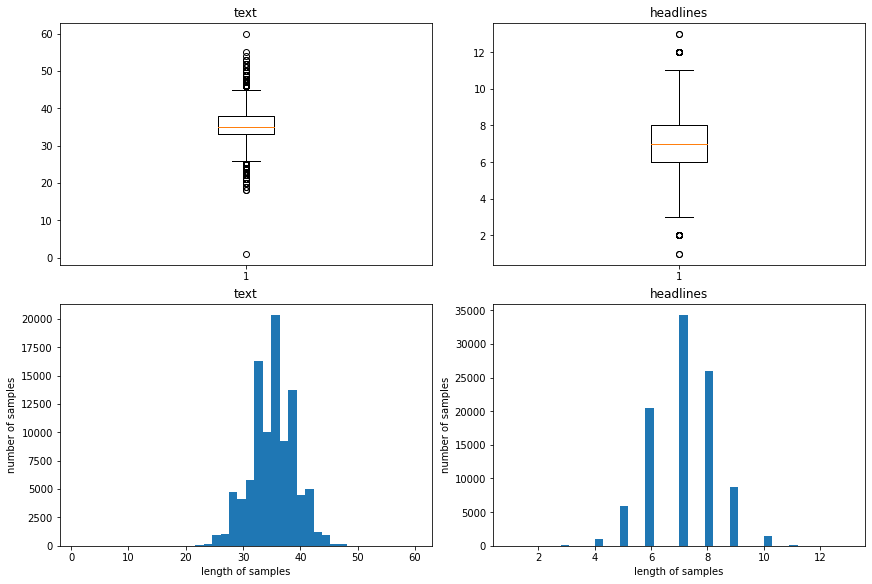

In [24]:
# 단어 수 그래프로 확인

fig, ax = plt.subplots(2, 2, figsize = (12, 8), constrained_layout=True)

ax[0, 0].boxplot(text_len)
ax[0, 0].set_title('text')

ax[0, 1].boxplot(summary_len)
ax[0, 1].set_title('headlines')

ax[1, 0].set_title('text')
ax[1, 0].hist(text_len, bins = 40)
ax[1, 0].set_xlabel('length of samples')
ax[1, 0].set_ylabel('number of samples')

ax[1, 1].set_title('headlines')
ax[1, 1].hist(summary_len, bins = 40)
ax[1, 1].set_xlabel('length of samples')
ax[1, 1].set_ylabel('number of samples')

plt.show()

In [27]:
print(text_len.quantile(0.95)) # 전체 원문 데이터의 95%를 포함하기 위한 단어의 수
print(text_len.quantile(0.90)) # 전체 원문 데이터의 90%를 포함하기 위한 단어의 수
print(text_len.quantile(0.85)) # 전체 원문 데이터의 85%를 포함하기 위한 단어의 수

print(summary_len.quantile(0.95)) # 전체 요약 데이터의 95%를 포함하기 위한 단어의 수
print(summary_len.quantile(0.90)) # 전체 요약 데이터의 90%를 포함하기 위한 단어의 수
print(summary_len.quantile(0.85)) # 전체 요약 데이터의 85%를 포함하기 위한 단어의 수

0    41.0
Name: 0.95, dtype: float64
0    40.0
Name: 0.9, dtype: float64
0    39.0
Name: 0.85, dtype: float64
0    9.0
Name: 0.95, dtype: float64
0    9.0
Name: 0.9, dtype: float64
0    8.0
Name: 0.85, dtype: float64


- 여러 지표를 확인하여 원문 데이터와 요약 데이터의 최대 단어 수를 각각 41, 9로 하고
- 최대 단어 수 보다 단어 수가 많은 데이터는 분석에서 제외하기로 결정

In [76]:
# 최대 단어 수 설정
text_max_len = 41
summary_max_len = 9

data = data[data['text'].apply(lambda x: len(x.split()) <= 41)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= 9)]

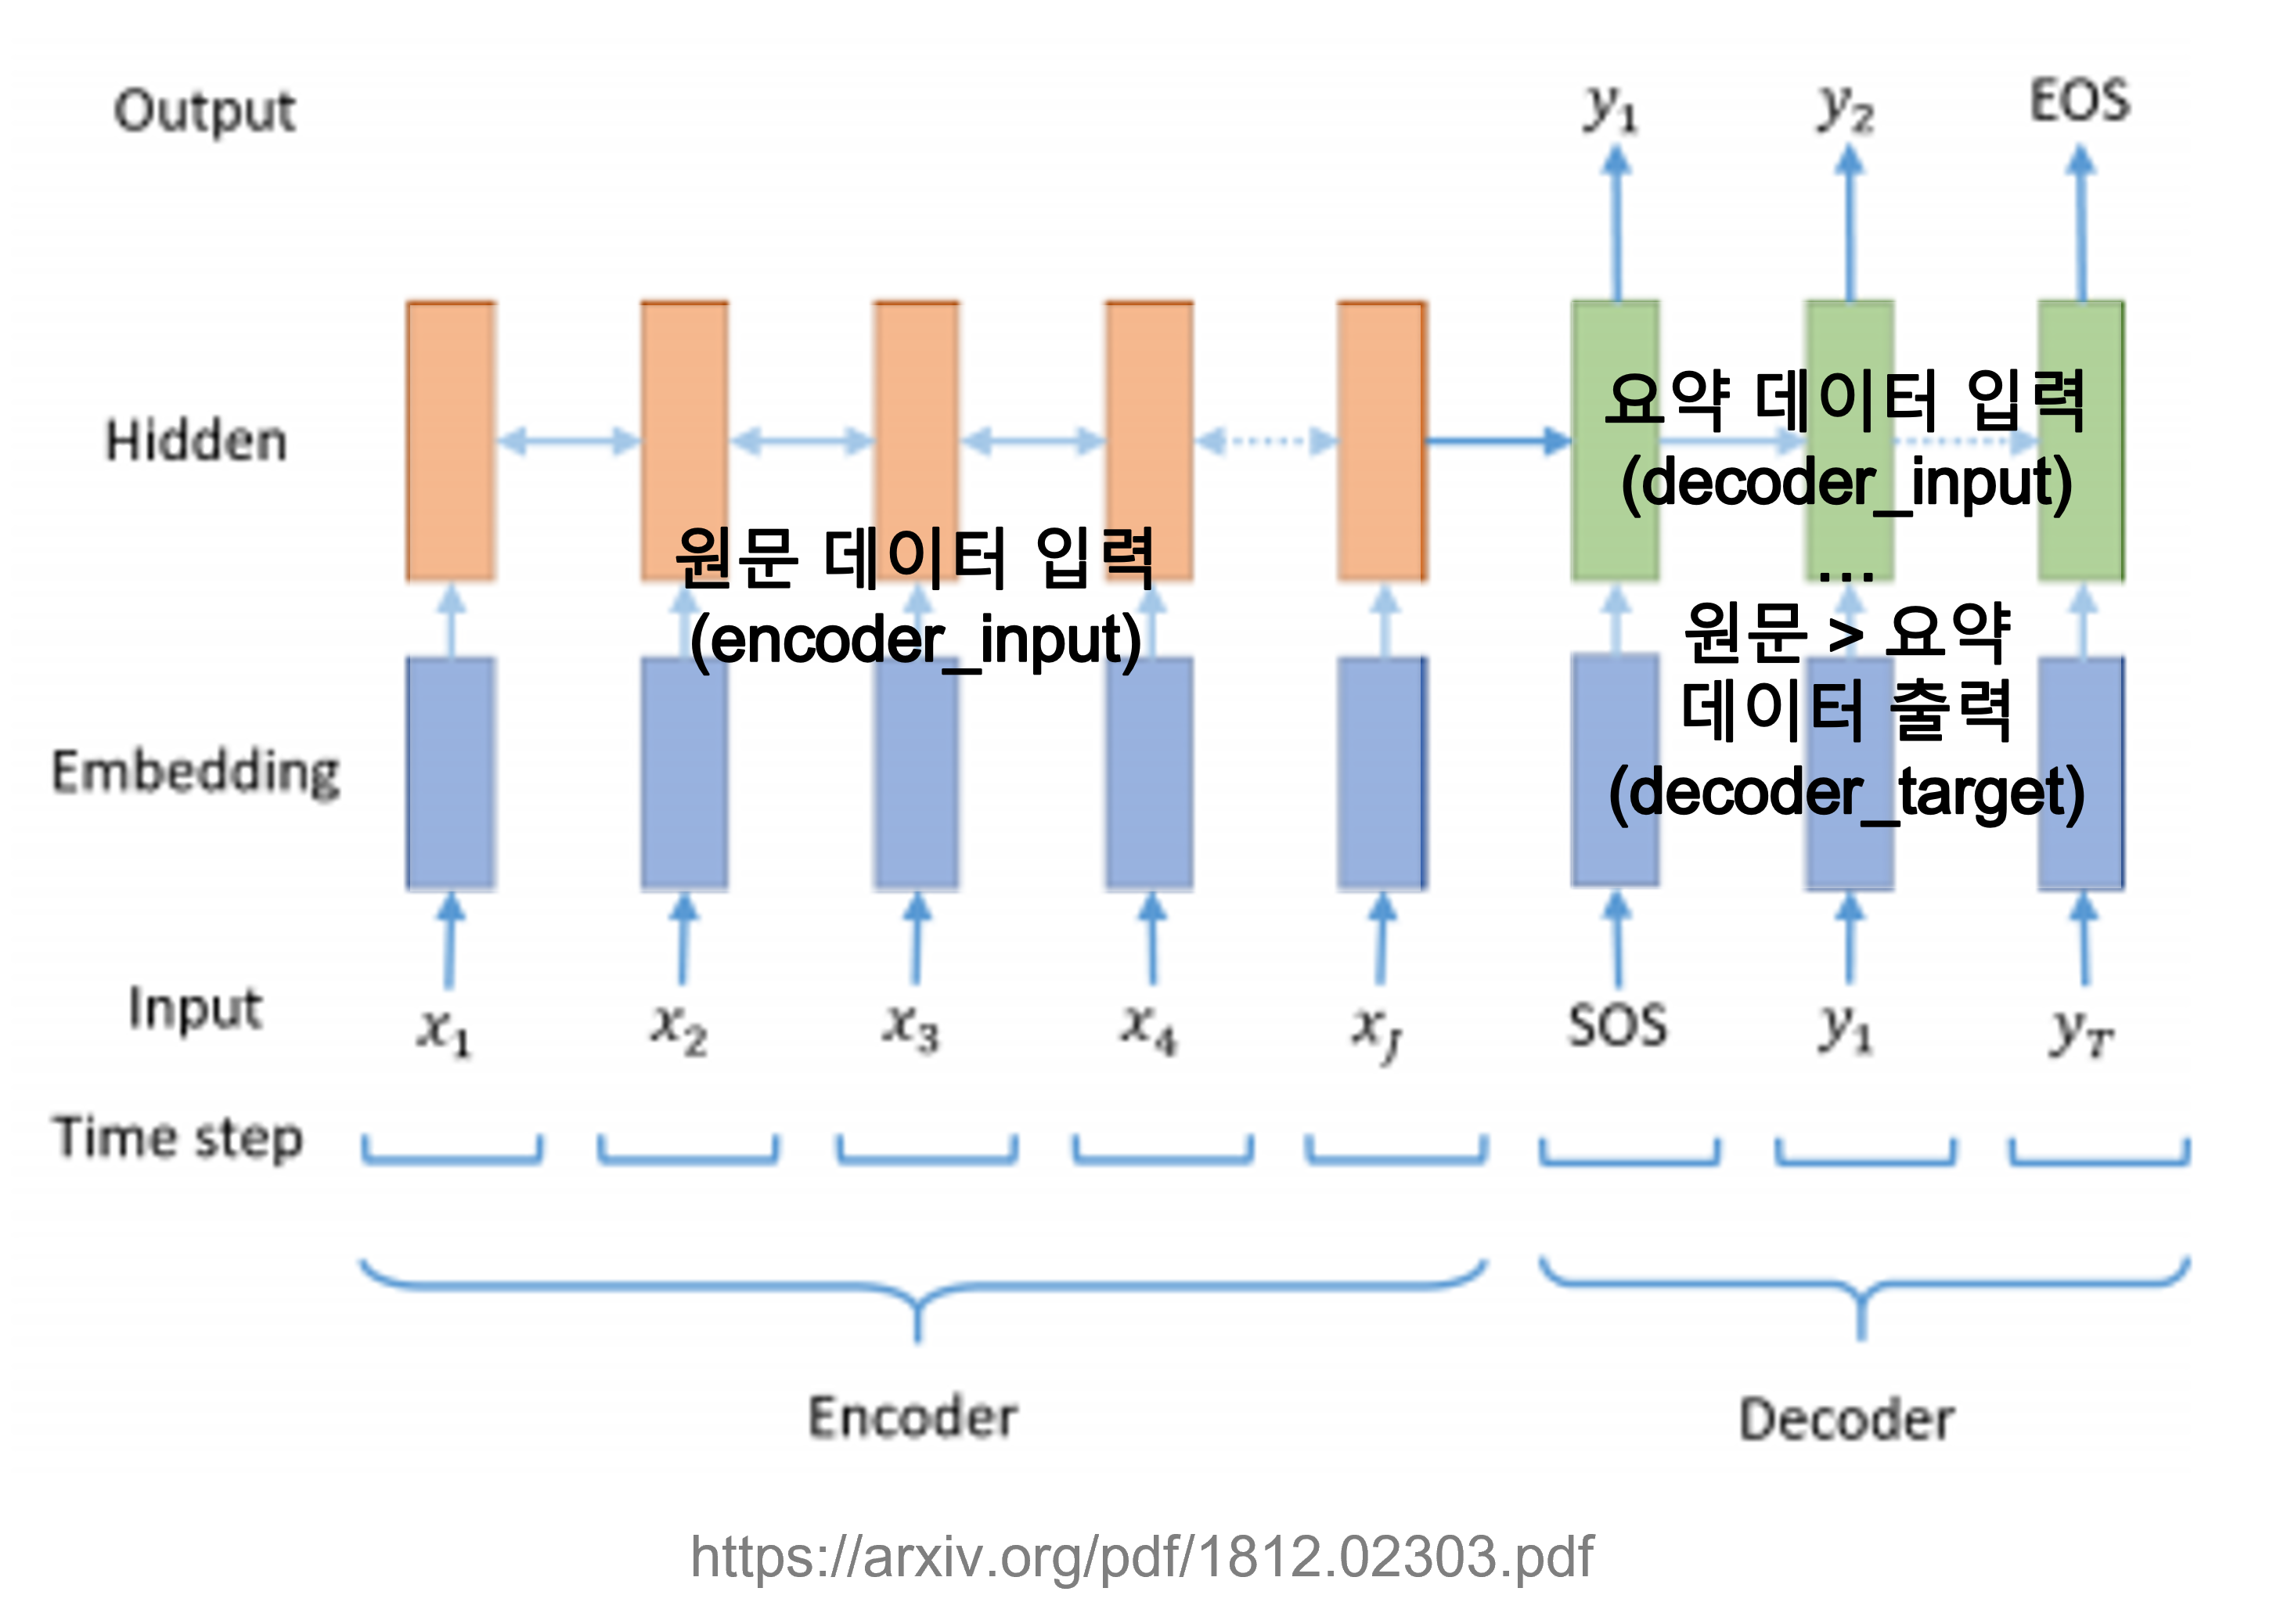

In [88]:
Image("seq2seq.png", width = 500)

시작/종료 토큰

In [31]:
# 디코더 인풋에 시작 토큰 (sostoken) 추가
# 디코더 타겟에 종료 토큰 (eostoken) 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

훈련 데이터와 시험 데이터 분리

In [32]:
# 인코더와 디코더 배열 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 출력

In [33]:
# 순서 섞기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [34]:
# 훈련 데이터와 시험 데이터 분리
tshape = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-tshape]
decoder_input_train = decoder_input[:-tshape]
decoder_target_train = decoder_target[:-tshape]

encoder_input_test = encoder_input[-tshape:]
decoder_input_test = decoder_input[-tshape:]
decoder_target_test = decoder_target[-tshape:]

print('encoder input train :', len(encoder_input_train))
print('decoder input train :', len(decoder_input_train))
print('encoder input test :', len(encoder_input_test))
print('decoder input test :', len(decoder_input_test))

encoder input train : 74028
decoder input train : 74028
encoder input test : 18506
decoder input test : 18506


#### 단어장 생성

In [36]:
# 단어장 생성
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

단어장의 크기 설정

In [53]:
# 단어장의 축소
threshold = 5 # 임계치
total_cnt = len(src_tokenizer.word_index) # 단어장 내 단어의 수
rare_cnt = 0 # 임계치 이하 빈도 단어의 수
total_freq = 0 # 단어장 내 빈도수 합
rare_freq = 0 # 임계치 이하 빈도 단어의 빈도수 합

for key, value in src_tokenizer.word_counts.items():
    total_freq += value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 66747
등장 빈도가 5번 미만인 희귀 단어의 수: 41301
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 25446
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7259696100597957


In [54]:
# 임계치 이하 빈도 단어를 제외하여 단어장 재생성
src_vocab = total_cnt - rare_cnt
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) 

단어에서 정수로 변환

In [55]:
# 단어 시퀀스 -> 정수 시퀀스
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

단어장 생성

In [64]:
# 요약 데이터 동일 작업 수행 (단어장 생성)
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

단어장의 크기 설정

In [70]:
# 요약 데이터 동일 작업 수행 (단어장 축소)
threshold = 2 # 임계치
total_cnt = len(tar_tokenizer.word_index) # 단어장 내 단어의 수
rare_cnt = 0 # 임계치 이하 빈도 단어의 수
total_freq = 0 # 단어장 내 빈도수 합
rare_freq = 0 # 임계치 이하 빈도 단어의 빈도수 합

for key, value in tar_tokenizer.word_counts.items():
    total_freq += value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: %s'%(total_cnt - rare_cnt))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28941
등장 빈도가 2번 미만인 희귀 단어의 수: 10235
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 18706
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7169016258144167


In [71]:
# 요약 데이터 동일 작업 수행 (임계치 이하 빈도 단어를 제외하여 단어장 재생성)
tar_vocab = total_cnt - rare_cnt
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

단어에서 정수로 변환

In [72]:
# 요약 데이터 동일 작업 수행 (단어 시퀀스 -> 정수 시퀀스)
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

null 확인

In [73]:
# 단어장 축소 후 토큰이 1개인 데이터 (시작 or 종료 토큰만 남은 데이터)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

# 데이터 제외
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

문장의 토큰 길이 설정

In [77]:
# 패딩 추가하여 토큰의 길이 맞춰주기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

#### 훈련 모델

인코더 설계

In [79]:
# 인코더 설계

# 파라미터
embedding_dim = 128
hidden_size = 256

# 인코더 선언
encoder_inputs = Input(shape=(text_max_len,))

# 인코더 임베딩
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

디코더 설계

In [81]:
# 디코더 설계

# 디코더 선언
decoder_inputs = Input(shape=(None,))

# 디코더 임베딩
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [82]:
# 모델 선언
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      3257088     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

어텐션 메커니즘

In [85]:
# 어텐션 메커니즘

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state를 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [86]:
# 모델 선언
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      3257088     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

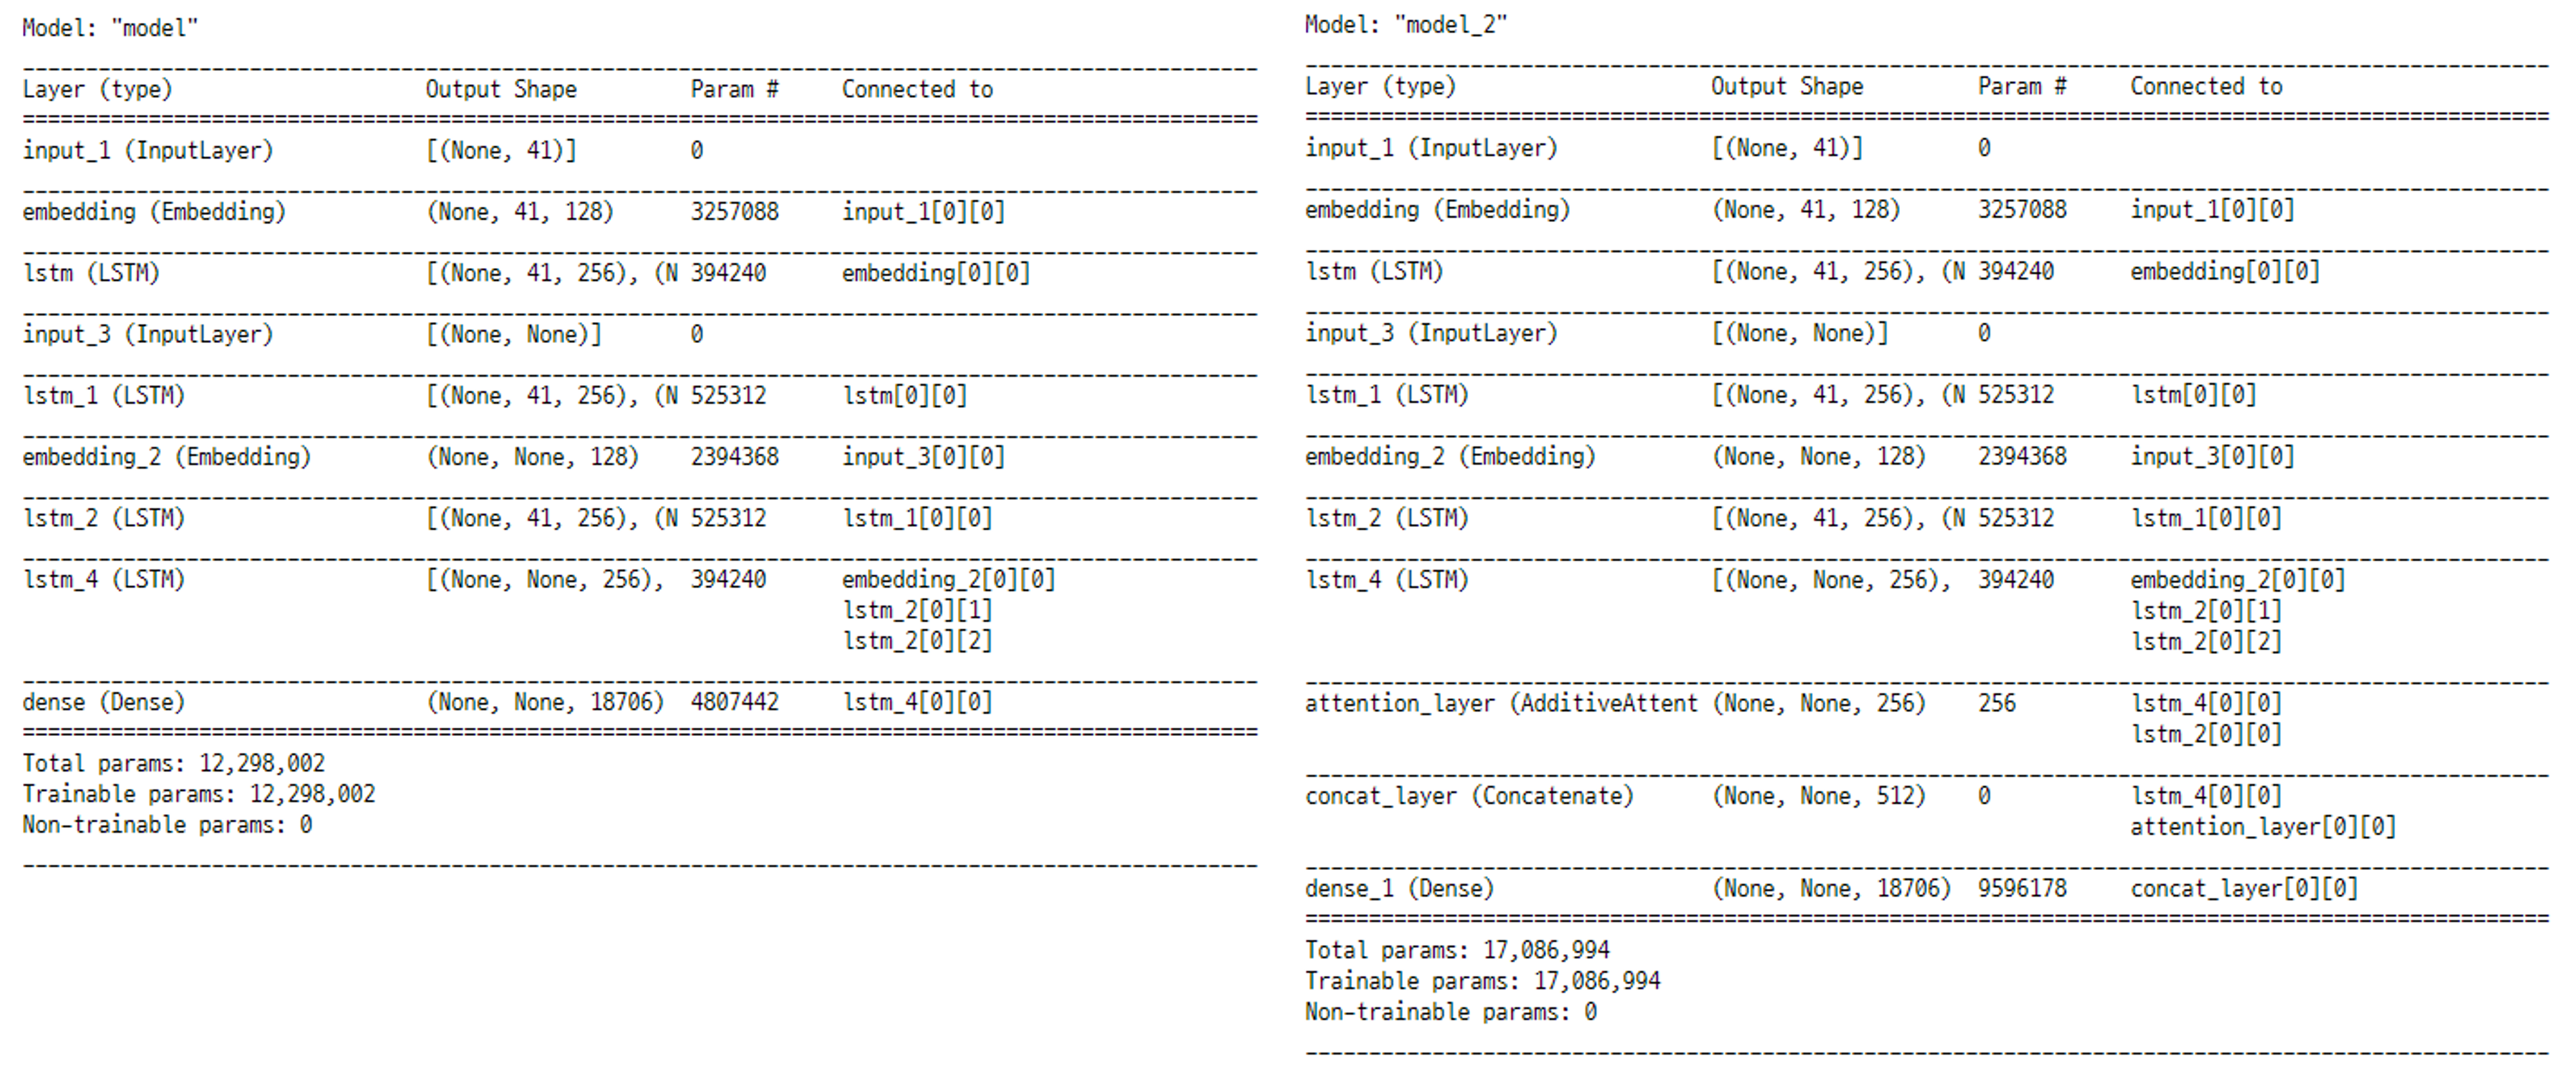

In [87]:
# 모델 비교
Image("model.png")

모델 훈련

In [89]:
# 모델 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# 검증 데이터의 loss가 줄지 않는 시점에 학습 종료 (early stop)
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# 모델 피팅
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
290/290 [==============================] - 174s 573ms/step - loss: 6.6422 - val_loss: 6.1576
Epoch 2/50
290/290 [==============================] - 165s 569ms/step - loss: 6.0679 - val_loss: 5.8205
Epoch 3/50
290/290 [==============================] - 164s 566ms/step - loss: 5.7056 - val_loss: 5.5349
Epoch 4/50
290/290 [==============================] - 164s 566ms/step - loss: 5.4346 - val_loss: 5.3730
Epoch 5/50
290/290 [==============================] - 164s 567ms/step - loss: 5.2124 - val_loss: 5.2034
Epoch 6/50
290/290 [==============================] - 165s 570ms/step - loss: 5.0171 - val_loss: 5.1093
Epoch 7/50
290/290 [==============================] - 164s 566ms/step - loss: 4.8535 - val_loss: 4.9952
Epoch 8/50
290/290 [==============================] - 165s 570ms/step - loss: 4.7099 - val_loss: 4.9063
Epoch 9/50
290/290 [==============================] - 165s 570ms/step - loss: 4.5847 - val_loss: 4.8373
Epoch 10/50
290/290 [==============================] - 165s 570m

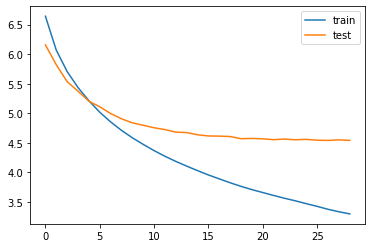

In [91]:
# 훈련 모델 결과
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 실전 모델 (인퍼런스 모델)

In [92]:
# 실전 모델 투입

# 정수 시퀀스 -> 단어 시퀀스
src_index_to_word = src_tokenizer.index_word
tar_index_to_word = tar_tokenizer.index_word

# 단어 시퀀스 -> 정수 시퀀스
tar_word_to_index = tar_tokenizer.word_index

인코더/디코더 설계

In [93]:
# 실전 모델 설계

# 인코더 모델
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 모델 학습에 대한 결과
decoder_state_input_h = Input(shape = (hidden_size, ))
decoder_state_input_c = Input(shape = (hidden_size, ))

# 디코더 임베딩
dec_emb2 = dec_emb_layer(decoder_inputs)

# 디코더 LSTM
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘

In [94]:
# 실전 어텐션 메커니즘

# hidden state 조정
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

모델 선언

In [95]:
# 실전 모델 선언
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [96]:
# 요약문 생성
def decode_sequence(input_seq):
    
    # 인코더의 결과 저장
    e_out, h, c = encoder_model.predict(input_seq)

    # 시작 토큰 (sostoken) 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # 디코더 결과
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, h, c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        # 문장에 토큰(단어) 추가
        if (sampled_token!='eostoken'):
            decoded_sentence += (' ' + sampled_token)

        #  종료 토큰 (eostoken) or 최대 길이 도달 -> 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 토큰 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence

#### 평가

In [97]:
# 원문: 정수 시퀀스 -> 문장
def seq2text(input_seq):
    result = ''
    for i in input_seq:
        if i != 0: 
            result += src_index_to_word[i]+' '
    return result

# 요약: 정수 시퀀스 -> 문장
def seq2summary(input_seq):
    result = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            result += tar_index_to_word[i] + ' '
    return result

요약문 생성

In [176]:
for i in range(20, 25):
    print("text :", seq2text(encoder_input_test[i]))
    print("headlines :", seq2summary(decoder_input_test[i]))
    print("predicted :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

text : uk prime minister theresa may rebuked us president donald trump remarks london terror attack saying helpful anybody speculate ongoing investigation another attack london loser terrorist sick people scotland yard must trump tweeted 
headlines : uk pm may rebukes trump remarks london terror attack 
predicted :  uk pm modi trump may kill trump


text : pakistan tallest man stands eight feet three inches tall said able find life partner far found someone tall enough almost impossible year old added said family took marriage proposal several families one showed interest 
headlines : almost impossible find tall enough partner pak tallest man 
predicted :  pak man walks foot tall foot tall


text : international team researchers dna fossils morocco dating approximately years ago making oldest nuclear dna africa ever successfully analysed study published journal science showed individuals dating late stone age genetic heritage related near eastern populations sub saharan africans 
headl

추출적 요약과 비교

In [124]:
# 추출적 요약은 주어진 문장 내에서 핵심 문장을 뽑는 방식

# 미리보기
data.reset_index()
text = data.loc[9, 'text']
print("text:", text)
print("summarize:", summarize(text, ratio = 0.4))

text: Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken its total to 100 seats in the 200-member assembly. The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.
summarize: Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.


In [157]:
print("encoder input text :")
print(seq2text(encoder_input_test[8]))
print("------------------------------------------------------")
print("decoder input headlines :")
print(seq2summary(decoder_input_test[8]))
print("------------------------------------------------------")
print("decoder ouput predicted :")
print(decode_sequence(encoder_input_test[8].reshape(1, text_max_len)))
print("------------------------------------------------------")

# 기존 텍스트가 변형 되었으므로 기사 원문을 찾아서 가져옴 
# (https://www.ibtimes.co.in/s-durga-nude-controversy-iffi-jury-head-sujoy-ghosh-resigns-749309?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle)
summa_input = "Director Sujoy Ghosh, who is known for films Kahaani and Ahalya, has resigned from the post of the jury head of the 48th\
International Film Festival of India (IFFI) over the controversy involving S Durga and Nude. \
IFFI is scheduled to be held from November 20 to 28 in Goa. \
The Information and Broadcasting Ministry announced the list of 'feature' and 'non-feature' films to be screened \
in the Indian Panorama section of IFFI. \
But two movies -- S Durga and Nude -- selected by a 13-member jury were removed from the final list. \
Some members of the jury were upset with the ministry for dropping S Durga and Nude from the final list of IFFI \
without consulting them. They had even gone on to criticise the decision, but the ministry stayed away from responding to the \
allegations. This has now led to Sujoy Ghosh stepping down from the post. Speaking to The Indian Express, Sujoy Ghosh confirmed \
the news, but declined to comment on the details of his decision. S Durga is a Malayalam movie, which has been written and directed \
by Sanal Sasidharan. The film exposes the reality of a misogynistic society and captures various encounters of a couple running away \
in the night. The movie recently received a U/A certificate from the censor board. S Durga was initially titled Sexy Durga, \
which was changed after censor board raised an objection. The makers of the movie were also forced to have 21 audio mutes \
by the board. The movie has already been screened at some international film festivals and has also won a few awards. \
On the other hand, Nude is a Marathi film, which has been written and directed by Ravi Jadhav. The movie explores the life \
and conflicts of a nude model at an art school. It was finalised as the opening film by the 13-member jury panel, but the I&B \
Ministry has replaced it with Vinod Kapri's Hindi movie Pihu. However, the news has come as a big shock to directors Sanal \
Sasidharan and Ravi Jadhav, who have expressed their disappointment and anguish. Sanal Sasidharan was earlier told that his film was \
in IFFI's final list, but now, he is sad about it being dropped. He said he is contemplating moving court against the government's \
move. \"I will be challenging this in court. But they have acted very smartly. It's just five days to IFFI. Don't know how fast we \
can move against the decision of dropping the movie,\" PTI quoted him as saying. Ravi Jadhav has written a letter to the ministry \
seeking to know why it was rejected. \"Give me some reason at least. It was selected as the opening film. It was a big honour. \
I am really disappointed and shocked to hear that it has been dropped. Nobody informed me about the decision,\" Jadhav told PTI."
print("summa input :")
print(summa_input)
print("------------------------------------------------------")
print("summarize:", summarize(summa_input, words = 20))

encoder input text :
filmmaker sujoy ghosh resigned post jury head th international film festival india following cancellation screenings films durga nude films dropped festival final list indian panorama section ministry information broadcasting without consulting jury members 
------------------------------------------------------
decoder input headlines :
iffi head resigns ministry dropping two films 
------------------------------------------------------
decoder ouput predicted :
 oscars women show oscars entry festival
------------------------------------------------------
summa input :
Director Sujoy Ghosh, who is known for films Kahaani and Ahalya, has resigned from the post of the jury head of the 48thInternational Film Festival of India (IFFI) over the controversy involving S Durga and Nude. IFFI is scheduled to be held from November 20 to 28 in Goa. The Information and Broadcasting Ministry announced the list of 'feature' and 'non-feature' films to be screened in the Indian P

- predicted의 경우 잘못된 요약, 의미 상의 오류, 핵심 단어를 포함하지 않음, 어법 상의 큰 오류
- summarize의 경우 핵심적인 문장을 담고 있으며 문법적으로 정확함 (사람이 쓴 문장을 가져왔기 때문에)
- 이 기사의 핵심 키워드는 "resign", predicted에는 없고 summarize에는 있음

In [179]:
print("encoder input text :")
print(seq2text(encoder_input_test[22]))
print("------------------------------------------------------")
print("decoder input headlines :")
print(seq2summary(decoder_input_test[22]))
print("------------------------------------------------------")
print("decoder ouput predicted :")
print(decode_sequence(encoder_input_test[22].reshape(1, text_max_len)))
print("------------------------------------------------------")

# 기존 텍스트가 변형 되었으므로 기사 원문을 찾아서 가져옴 
# (https://www.mpg.de/11978445/genomic-ancestry-of-stone-age-north-africans-from-morocco?c=2249&utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle)
summa_input = "An international team of researchers, led by Johannes Krause and Choongwon Jeong from the Max Planck Institute \
for the Science of Human History (Jena, Germany), and Abdeljalil Bouzouggar from the Institut National des Sciences \
de l’Archéologie et du Patrimoine (Rabat, Morocco) and including scientists from the Mohammed V University in Rabat, \
the Natural History Museum in London, University of Oxford, Université Mohammed Premier in Oujda and the Max Planck Institute \
for Evolutionary Anthropology in Leipzig, have sequenced DNA from individuals from Morocco dating to approximately 15,000 years ago, \
as published in Science. This is the oldest nuclear DNA from Africa ever successfully analyzed. The individuals, dating \
to the Late Stone Age, had a genetic heritage that was in part similar to Near Eastern populations and in part related \
to sub-Saharan African populations. North Africa is an important area in the history of the evolution of our species. The geography \
of North Africa also makes it an interesting area for studying how humans expanded out of Africa. It is part \
of the African continent, but the Sahara desert presents a substantial barrier to travel to and from southern regions. Similarly, \
it is part of the Mediterranean region, but in the past the sea could have presented a barrier to interaction with others as well. \
“A better understanding of the history of North Africa is critical to understanding the history of our species,” explains \
co-author Saaïd Amzazi of Mohammed V University in Rabat, Morocco. In order to address this, the team looked at a burial site \
in Grotte des Pigeons, near Taforalt in Morocco, associated with the Later Stone Age Iberomaurusian culture. The Iberomaurusians \
are believed to be the first in the area to produce finer stone tools known as microliths. “Grotte des Pigeons is a crucial site \
to understanding the human history of north-western Africa, since modern humans frequently inhabited this cave intensively during \
prolonged periods throughout the Middle and Later Stone Age,” explains co-author Louise Humphrey of the Natural History Museum \
in London. “Around 15,000 years ago there is evidence for more intensive use of the site and the Iberomaurusians started to bury \
their dead at the back of the cave.”"
print("summa input :")
print(summa_input)
print("------------------------------------------------------")
print("summarize:", summarize(summa_input, words = 30))

encoder input text :
international team researchers dna fossils morocco dating approximately years ago making oldest nuclear dna africa ever successfully analysed study published journal science showed individuals dating late stone age genetic heritage related near eastern populations sub saharan africans 
------------------------------------------------------
decoder input headlines :
year old human dna oldest recovered africa 
------------------------------------------------------
decoder ouput predicted :
 oldest ever ever found human species found
------------------------------------------------------
summa input :
An international team of researchers, led by Johannes Krause and Choongwon Jeong from the Max Planck Institute for the Science of Human History (Jena, Germany), and Abdeljalil Bouzouggar from the Institut National des Sciences de l’Archéologie et du Patrimoine (Rabat, Morocco) and including scientists from the Mohammed V University in Rabat, the Natural History Museum in

- predicted의 경우 어법 상 아주 적절하지는 않지만, 의미를 제법 잘 전달하고 있음
- summarize의 경우 문법적으로 완성도 있는 문장이지만, 결과 문장만으로 기사 내용을 추측하기 어려움
- 이 기사를 한마디로 표현하자면 "인간 종의 발견"이고, predicted는 명확하게 밝히고 있으며 summarize는 간접적으로 밝히고 있음

### 프로젝트 평가 및 한계

- Predicted 문장의 퀄리티 <br/>
데이터에 따라서 문장이 기사를 잘 요약하고 있는 경우도 있었지만, 대체로 잘 수행해내지 못했다.<br/>
또한 문장이 기사를 잘 요약하고 있다고 하더라도 문법적으로 큰 오류를 범하고 있기에 이를 활용하는 데 많은 어려움이 있을 것이라 생각된다.<br/>
문장의 퀄리티를 올리기 위해서는 이미 충분히 학습된 워드 임베딩을 사용하거나, 더 많은 train 데이터를 투입하는 방법이 있을 것 같다.<br/>

- Summarize 문장의 퀄리티 <br/>
추출적 요약은 데이터의 여러 문장 중 한 문장을 뽑는 것이다.<br/>
따라서 데이터의 문장 개수가 적을 경우 세 문장을 관통하는 핵심적인 문장을 뽑는 기능이 없다.<br/>
즉, 데이터의 크기 자체가 커야 한다는 것이다.<br/>
또한 일정 이상의 크기를 가진 데이터(예를 들면 뉴스 기사)라고 할지라도 결과 문장이 기사 내용을 추정하는 역할을 수행하기에 부족함이 많아 보인다.<br/>